In [24]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

# Assuming df is your DataFrame and 'text' is the column with notes


In [25]:
df = pd.read_csv('/content/bquxjob_11ab4ee4_18b56aefd7d.csv')

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure the necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Define the set of stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())  # Convert to lowercase
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)

# Apply the preprocessing function to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
# Initialize the TfidfVectorizer with the required parameters
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)

# Transform the 'text' column using the vectorizer
X = vectorizer.fit_transform(df['processed_text'])


In [28]:
# Perform clustering on the TF-IDF transformed data
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=200).fit(X)

# Assign the cluster labels to a new column in the dataframe
df['cluster'] = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
# Define the keywords for each HAI category
keywords = {
    "CAUTI": ["catheter", "urinary", "uti", "bladder"],  # Add more domain-specific keywords
    "CLABSI": ["central", "line", "bloodstream"],
    "VAP": ["ventilator", "pneumonia", "lung"]
}

# Compile a dictionary of keywords for faster checking
keyword_dict = {word: hai for hai, words in keywords.items() for word in words}


In [30]:
def assign_hai_category(cluster, text):
    for word in keyword_dict:
        if word in text:
            return keyword_dict[word]
    return f"Cluster_{cluster}"

df['HAI_category'] = df.apply(lambda row: assign_hai_category(row['cluster'], row['text'].lower()), axis=1)

# Display the results
print(df[['subject_id', 'HAI_category']])


     subject_id HAI_category
0      12705235        CAUTI
1      12722192        CAUTI
2      12763117        CAUTI
3      12796618        CAUTI
4      12829139        CAUTI
..          ...          ...
951    14491638        CAUTI
952    10007058       CLABSI
953    10169178        CAUTI
954    10296683    Cluster_1
955    10538657        CAUTI

[956 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


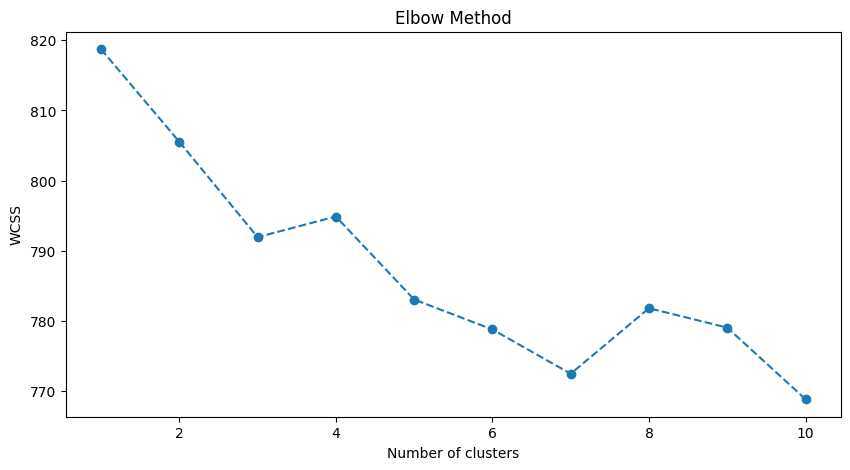

In [31]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use the Elbow method to find a good number of clusters using WCSS (Within-Cluster-Sum-of-Squares)
wcss = []

# Let's check for up to 10 clusters
for i in range(1, 11):
    kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', random_state=42, batch_size=200)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the Elbow curve, select the number of clusters (for this example, I'll continue using 3)
optimal_clusters = 3  # replace with the optimal number based on the curve
kmeans = MiniBatchKMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42, batch_size=200)

# Fitting the model
kmeans.fit(X)

# Assigning clusters to the dataframe
df['cluster'] = kmeans.labels_


In [32]:
# Selecting 'subject_id' and 'cluster' columns from the dataframe
clustered_data = df[['subject_id', 'cluster']]

# Display the first few rows (or more, depending on your preference)
print(clustered_data.head())


   subject_id  cluster
0    12705235        1
1    12722192        0
2    12763117        0
3    12796618        0
4    12829139        1


In [15]:
df['HAI_category']

0          CAUTI
1          CAUTI
2          CAUTI
3          CAUTI
4          CAUTI
         ...    
951        CAUTI
952       CLABSI
953        CAUTI
954    Cluster_1
955        CAUTI
Name: HAI_category, Length: 956, dtype: object

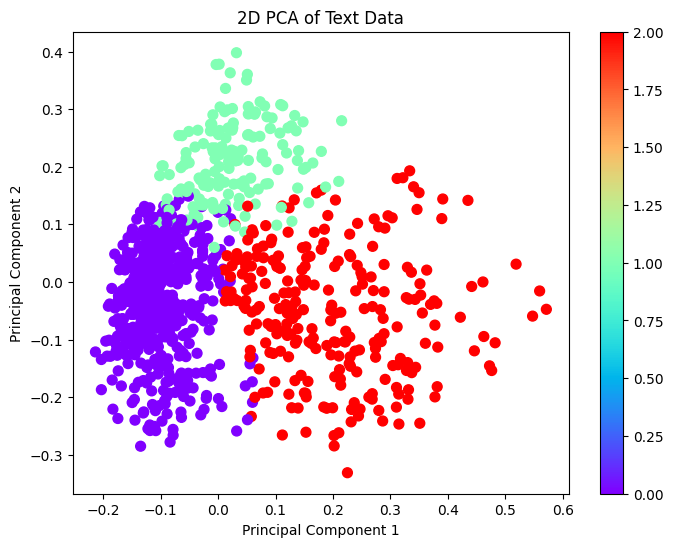

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the data to 2D using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

# Plotting the reduced data
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster'], cmap='rainbow', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Text Data')
plt.colorbar()
plt.show()


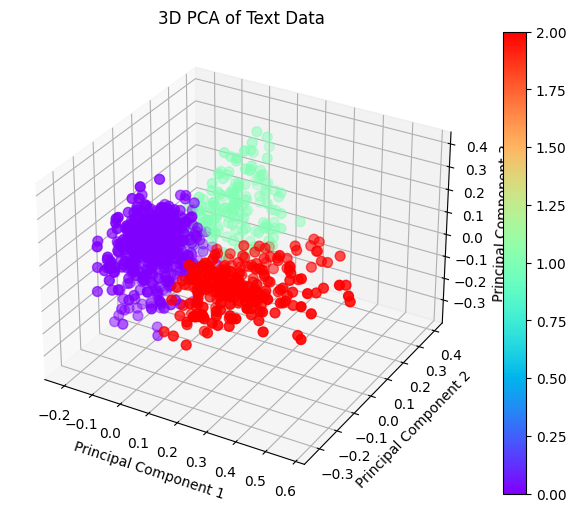

In [34]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce the data to 3D using PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(X.toarray())

# Plotting the reduced data in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['cluster'], cmap='rainbow', s=50)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Text Data')
fig.colorbar(scatter)
plt.show()


In [35]:
# View the size of each cluster
cluster_sizes = df['cluster'].value_counts()
print(cluster_sizes)


0    543
2    257
1    156
Name: cluster, dtype: int64


In [36]:
def top_terms(cluster_num, terms=10):
    members = df[df['cluster'] == cluster_num]['processed_text']
    combined_text = ' '.join(members)
    token_freq = nltk.FreqDist(combined_text.split())
    return token_freq.most_common(terms)

for cluster_num in range(optimal_clusters):  # replace 'optimal_clusters' with the number of clusters you have
    print(f"Top terms for cluster {cluster_num}: {top_terms(cluster_num)}\n")


Top terms for cluster 0: [('mg', 9295), ('po', 8717), ('blood', 6734), ('daily', 5565), ('discharge', 5151), ('patient', 4258), ('history', 3695), ('pain', 3581), ('admission', 2926), ('left', 2651)]

Top terms for cluster 1: [('pain', 1871), ('mg', 1820), ('po', 1511), ('discharge', 1440), ('patient', 1409), ('medications', 948), ('blood', 924), ('history', 825), ('daily', 799), ('please', 798)]

Top terms for cluster 2: [('tablet', 5159), ('mg', 3817), ('sig', 3123), ('po', 3093), ('daily', 2845), ('one', 2481), ('blood', 2078), ('discharge', 2065), ('day', 2025), ('pain', 1817)]



In [37]:
def keyword_count(cluster_num, keyword):
    members = df[df['cluster'] == cluster_num]['processed_text']
    combined_text = ' '.join(members)
    return combined_text.lower().count(keyword.lower())

for cluster_num in range(optimal_clusters):
    for category, keywords_list in keywords.items():
        keyword_counts = {keyword: keyword_count(cluster_num, keyword) for keyword in keywords_list}
        print(f"Keyword counts for cluster {cluster_num} in category {category}: {keyword_counts}\n")


Keyword counts for cluster 0 in category CAUTI: {'catheter': 338, 'urinary': 303, 'uti': 954, 'bladder': 263}

Keyword counts for cluster 0 in category CLABSI: {'central': 117, 'line': 1551, 'bloodstream': 8}

Keyword counts for cluster 0 in category VAP: {'ventilator': 27, 'pneumonia': 434, 'lung': 1237}

Keyword counts for cluster 1 in category CAUTI: {'catheter': 76, 'urinary': 46, 'uti': 248, 'bladder': 41}

Keyword counts for cluster 1 in category CLABSI: {'central': 7, 'line': 211, 'bloodstream': 0}

Keyword counts for cluster 1 in category VAP: {'ventilator': 1, 'pneumonia': 19, 'lung': 55}

Keyword counts for cluster 2 in category CAUTI: {'catheter': 96, 'urinary': 88, 'uti': 425, 'bladder': 87}

Keyword counts for cluster 2 in category CLABSI: {'central': 46, 'line': 572, 'bloodstream': 0}

Keyword counts for cluster 2 in category VAP: {'ventilator': 14, 'pneumonia': 154, 'lung': 373}



In [38]:
original_clusters = df['cluster'].values
changed_count = 0

# Rerun clustering with a different random state
kmeans_new = MiniBatchKMeans(n_clusters=optimal_clusters, random_state=0, batch_size=200)  # Using a different random state
kmeans_new.fit(X)
new_clusters = kmeans_new.labels_

for orig, new in zip(original_clusters, new_clusters):
    if orig != new:
        changed_count += 1

print(f"Number of data points that changed clusters: {changed_count}")


Number of data points that changed clusters: 916


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
CAUTI (Catheter-Associated Urinary Tract Infections) keywords:
'catheter': 338
'urinary': 303
'uti': 954
'bladder': 263
CLABSI (Central Line-Associated Bloodstream Infections) keywords:
'central': 117
'line': 1551
'bloodstream': 8
VAP (Ventilator-Associated Pneumonia) keywords:
'ventilator': 27
'pneumonia': 434
'lung': 1237
Cluster 1:
CAUTI keywords:
'catheter': 76
'urinary': 46
'uti': 248
'bladder': 41
CLABSI keywords:
'central': 7
'line': 211
'bloodstream': 0
VAP keywords:
'ventilator': 1
'pneumonia': 19
'lung': 55
Cluster 2:
CAUTI keywords:
'catheter': 96
'urinary': 88
'uti': 425
'bladder': 87
CLABSI keywords:
'central': 46
'line': 572
'bloodstream': 0
VAP keywords:
'ventilator': 14
'pneumonia': 154
'lung': 373


Analysis:
Cluster 0:
Dominant in terms of mentions across all three HAI categories.
Especially strong on "CAUTI" and "VAP" related keywords.
May represent more general clinical notes where different hospital-acquired conditions are discussed or recorded.
Cluster 1:
Significantly fewer mentions across all HAI keywords compared to Cluster 0.
Might represent specific cases or specialized areas where HAIs are not the primary concern.
Cluster 2:
Has a good representation of HAI keywords, especially for "CAUTI".
Perhaps a middle ground between Cluster 0 and 1 in terms of HAI focus.
Inferences:
Cluster 0 might represent patients with a broader range of HAI symptoms or discussions around HAIs.
Cluster 1 seems less concerned with HAIs specifically, based on the low keyword frequency.
Cluster 2 may represent another subset of patients where HAIs, especially CAUTI, are a prominent concern but not as broad as Cluster 0.

In [39]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", score)


Silhouette Score: 0.017666086495441477
